In [43]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, EditedNearestNeighbours
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
def plot_2d_space(X_train, y_train,X,y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

In [3]:
train_transaction = pd.read_csv('../train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('../train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('../sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

X_train = X_train.fillna(-999)
X_test = X_test.fillna(-999)

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))

(590540, 433)
(506691, 432)


In [4]:
ran_over = RandomOverSampler(random_state=42)
X_train_oversample,y_train_oversample = ran_over.fit_resample(X_train,y_train)

In [5]:
ran_under = RandomUnderSampler(random_state=42)
X_train_undersample, y_train_undersample = ran_under.fit_resample(X_train,y_train)

In [6]:
tl = TomekLinks(n_jobs=6)
X_train_tl, y_train_tl = tl.fit_sample(X_train, y_train)

In [7]:
sm = SMOTE(random_state=42, n_jobs=5)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [8]:
print(np.unique(y_train, return_counts=True))
print("after sampling")
print("randomg over sampling")
print(np.unique(y_train_oversample, return_counts=True))
print("SMOTE sampling")
print(np.unique(y_train_sm, return_counts=True))
print("random under sampling")
print(np.unique(y_train_undersample, return_counts=True))
print("TomekLinks under sampling")
print(np.unique(y_train_tl, return_counts=True))

(array([0, 1]), array([569877,  20663]))
after sampling
randomg over sampling
(array([0, 1]), array([569877, 569877]))
SMOTE sampling
(array([0, 1]), array([569877, 569877]))
random under sampling
(array([0, 1]), array([20663, 20663]))
TomekLinks under sampling
(array([0, 1]), array([562770,  20663]))


In [ ]:
clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    missing=-999,
    random_state=2020,
    n_jobs=5,
    tree_method='hist'  # THE MAGICAL PARAMETER
)

%time clf.fit(X_train, y_train)

In [ ]:
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('../simple_xgboost.csv')

In [32]:
pos = np.unique(y_train, return_counts=True)[1][0]
neg = len(y_train)-pos

In [38]:
pos/neg

27.579586700866283

In [39]:
params = {
        'n_estimators': [256,512,1024],
        'max_depth': [3,6,9],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'scale_pos_weight': [1,14,27]
        }

In [ ]:
clf = xgb.XGBClassifier(
    missing=-999,
    random_state=2020,
    nthread=5,
    tree_method='hist'  # THE MAGICAL PARAMETER
)

gsearch = RandomizedSearchCV(clf,
                         param_distributions=params,
                         scoring='roc_auc', 
                         n_jobs=-1)
gsearch.fit(X_train, y_train)
gsearch.best_params_
# sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
# sample_submission.to_csv('../simple_xgboost_sm_oversample.csv')

In [ ]:
enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X_train, y_train)

In [ ]:
clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    missing=-999,
    random_state=2020,
    n_jobs=5,
    tree_method='hist'
)
%time clf.fit(X_resampled, y_resampled)
sample_submission['isFraud'] = clf.predict_proba(X_test)[:,1]
sample_submission.to_csv('../simple_xgboost_ENN_oversample.csv')

In [9]:
# visualization
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(X_train)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_train)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_train)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))





T-SNE took 4e+03 s
PCA took 5.1 s
Truncated SVD took 3.6 s


In [10]:
t0 = time.time()
X_tl_reduced_tsne = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(X_train_tl)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_tl_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_train_tl)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_tl_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_train_tl)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 3.7e+03 s
PCA took 4.9 s
Truncated SVD took 3.6 s


In [11]:
t0 = time.time()
X_sm_reduced_tsne = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(X_train_sm)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_sm_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_train_sm)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_sm_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_train_sm)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.8e+03 s
PCA took 9.8 s
Truncated SVD took 7.2 s


In [12]:
np.save("../data/X_reduced_tsne.npy", X_reduced_tsne)
np.save("../data/X_reduced_pca.npy", X_reduced_pca)
np.save("../data/X_reduced_svd.npy", X_reduced_svd)
np.save("../data/X_tl_reduced_tsne.npy", X_tl_reduced_tsne)
np.save("../data/X_tl_reduced_pca.npy", X_tl_reduced_pca)
np.save("../data/X_tl_reduced_svd.npy", X_tl_reduced_svd)
np.save("../data/X_sm_reduced_tsne.npy", X_sm_reduced_tsne)
np.save("../data/X_sm_reduced_pca.npy", X_sm_reduced_pca)
np.save("../data/X_sm_reduced_svd.npy", X_sm_reduced_svd)

In [24]:
y = np.array(y_train)

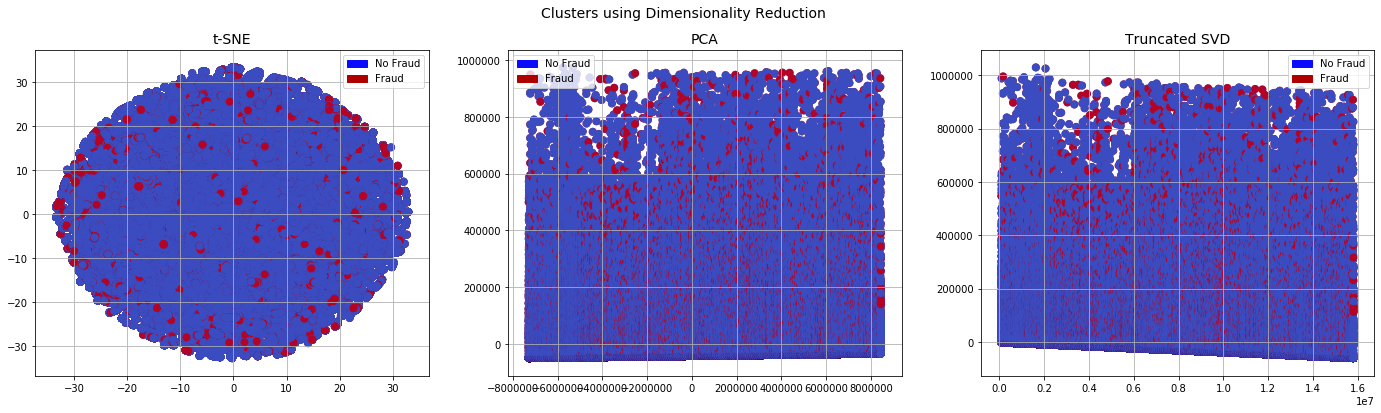

In [26]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()